In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

In [2]:
df = pd.read_parquet("muestreos_parcelas.parquet")

In [3]:
estados = [
    "estado_fenologico_1",
    "estado_fenologico_2",
    "estado_fenologico_3",
    "estado_fenologico_4",
    "estado_fenologico_5",
    "estado_fenologico_6",
    "estado_fenologico_7",
    "estado_fenologico_8",
    "estado_fenologico_9",
    "estado_fenologico_10",
    "estado_fenologico_11",
    "estado_fenologico_12",
    "estado_fenologico_13",
    "estado_fenologico_14",
]


# Removing null values
df = df.dropna(subset=estados, how="all")
df = df.dropna(subset=["codparcela"])

# Sorting and removing null by date
df["fecha"] = pd.to_datetime(df["fecha"])
df.sort_values(by="fecha", inplace=True)

n_parcelas = len(df.codparcela.value_counts()[df.codparcela.value_counts()>0])

In [4]:
# Adding the number of days till next visit for each row
df["next_date"] = df.groupby("codparcela", observed=True)["fecha"].shift(-1)
df["days_until_next_visit"] = (df["next_date"] - df["fecha"]).dt.days


# Removing the parcels with only one entry and the last entry for every parcel (we would need to also add the y value of the next entry)

df = df.dropna(subset=["days_until_next_visit"])  # 5150 entries removed
df["days_until_next_visit"] = df["days_until_next_visit"].astype("int32")

(1.0, 30.0)

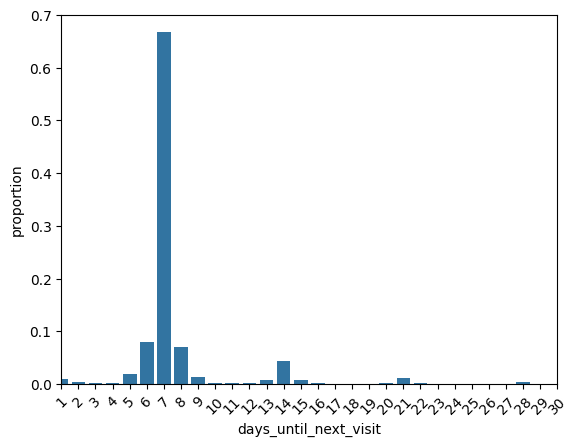

In [5]:
sns.countplot(x="days_until_next_visit", stat="proportion", data=df)
plt.xticks(rotation=45)
plt.xlim(1, 30)

In [6]:
print(len(df))
df_reduced = df[df["days_until_next_visit"] < 30]  # 18.7k entries removed
print(len(df_reduced))
df_reduced_10_days = df[df["days_until_next_visit"] < 10]  # 69.3k entries removed
print(len(df_reduced_10_days))

563684
544983
494366


In [7]:
# Value Counts for both cases
df_value_counts = df_reduced["codparcela"].value_counts()
df_value_counts = df_value_counts[df_value_counts > 0]
df_value_counts_10_days = df_reduced_10_days["codparcela"].value_counts()
df_value_counts_10_days = df_value_counts_10_days[df_value_counts_10_days > 0]

In [8]:
#df_reduced[df_reduced["codparcela"] == "015-00002-00-00"].iloc[:50,]

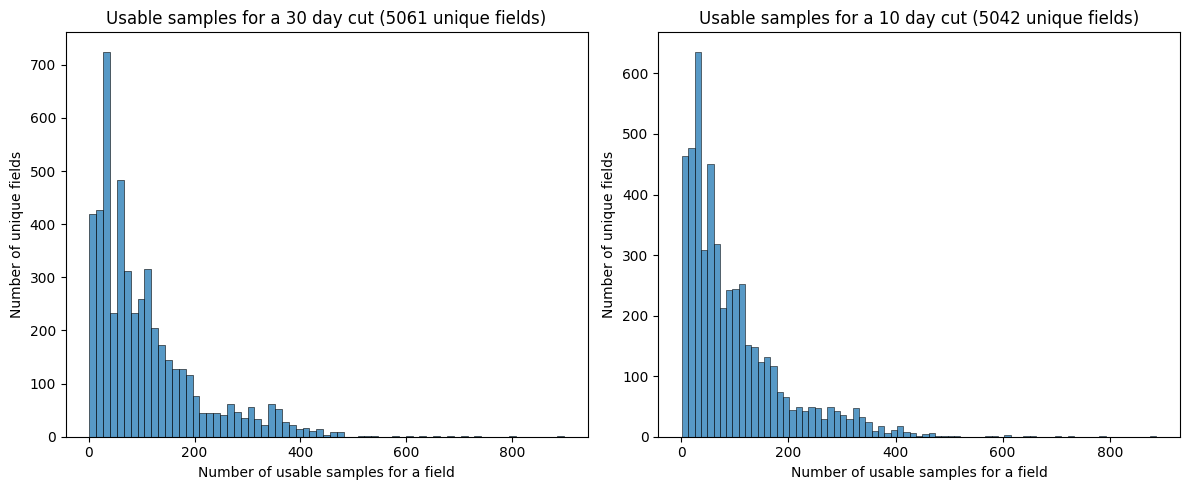

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

sns.histplot(data=df_value_counts, ax=axes[0])
axes[0].set_xlabel("Number of usable samples for a field")
axes[0].set_ylabel("Number of unique fields")
axes[0].set_title(
    f"Usable samples for a 30 day cut ({len(df_value_counts)} unique fields)"
)

sns.histplot(data=df_value_counts_10_days, ax=axes[1])
axes[1].set_xlabel("Number of usable samples for a field")
axes[1].set_ylabel("Number of unique fields")
axes[1].set_title(
    f"Usable samples for a 10 day cut ({len(df_value_counts_10_days)} unique fields)"
)

plt.tight_layout()

plt.show()

### Analizing the cases were the growth stage decreases after increasing.

In [10]:
# Filtering rows that contain more or less than one unique 2.

df.loc[:, "count_2s"] = df[estados].eq(2).sum(axis=1)
df = df[df.count_2s == 1]

In [11]:
def find_column_with_value_two(row):
    for column in row.index:
        if row[column] == 2:
            number_growth_stage = int(column.split("_")[-1])
            return number_growth_stage


df["estado_principal"] = df[estados].apply(find_column_with_value_two, axis=1)

In [12]:
df["next_estado"] = df.groupby("codparcela", observed=True)["estado_principal"].shift(-1)

# Removing the parcels with only one entry and the last entry for every parcel

df = df.dropna(subset=["next_estado"])  # 5150 entries removed
df["next_estado"] = df["next_estado"].astype("int32")


def is_next_stado_less_than_current(row):
    if row["next_estado"] - row["estado_principal"] < 0:
        return 1
    else:
        return 0


df["estado_decreased"] = df.apply(is_next_stado_less_than_current, axis=1)
df["estado_decreased"].sum() / len(df)

0.03967196990365148

In around 4% of the rows the growth stage decreases in the next measure of the period.

In [14]:
def get_valid_dataset(df: pd.DataFrame(), max_days_till_next_date: int) -> pd.DataFrame():
    # Removing null
    df = df.dropna(subset=estados, how="all")
    df = df.dropna(subset=["codparcela"])

    # Sorting by date
    df["fecha"] = pd.to_datetime(df["fecha"])
    df.sort_values(by="fecha", inplace=True)

    # Getting columns needed to remove dates that are far apart
    df["next_date"] = df.groupby("codparcela", observed=True)["fecha"].shift(-1)
    df["days_until_next_visit"] = (df["next_date"] - df["fecha"]).dt.days

    # Removing the parcels with only one entry and the last entry for every parcel
    df = df.dropna(subset=["days_until_next_visit"])  # 5150 entries removed
    df["days_until_next_visit"] = df["days_until_next_visit"].astype("int32")

    # Filtering the max days
    df = df[df["days_until_next_visit"] < max_days_till_next_date]

    return df.loc[:, [i for i in df.columns if i not in ["next_date", "days_until_next_visit"]]]


df_new = get_valid_dataset(df, 10)


print(f"Numero de parcelas base: {n_parcelas}")
for i in range(1, 90, 7):
    df_new = get_valid_dataset(df, i)
    print(f"Numero max de dias entre muestras: {i}, numero parcelas: {len(df_new.codparcela.value_counts()[df_new.codparcela.value_counts()>0])}")

print("Only from 2016:")
for i in range(1, 90, 7):
    df_new = get_valid_dataset(df[df["fecha"].dt.year >= 2016], i)
    print(f"Numero max de dias entre muestras: {i}, numero parcelas: {len(df_new.codparcela.value_counts()[df_new.codparcela.value_counts()>0])}")



Numero de parcelas base: 5150
Numero max de dias entre muestras: 1, numero parcelas: 156
Numero max de dias entre muestras: 8, numero parcelas: 4936
Numero max de dias entre muestras: 15, numero parcelas: 4961
Numero max de dias entre muestras: 22, numero parcelas: 4965
Numero max de dias entre muestras: 29, numero parcelas: 4966
Numero max de dias entre muestras: 36, numero parcelas: 4971
Numero max de dias entre muestras: 43, numero parcelas: 4971
Numero max de dias entre muestras: 50, numero parcelas: 4971
Numero max de dias entre muestras: 57, numero parcelas: 4971
Numero max de dias entre muestras: 64, numero parcelas: 4971
Numero max de dias entre muestras: 71, numero parcelas: 4971
Numero max de dias entre muestras: 78, numero parcelas: 4971
Numero max de dias entre muestras: 85, numero parcelas: 4971
Only from 2016:
Numero max de dias entre muestras: 1, numero parcelas: 27
Numero max de dias entre muestras: 8, numero parcelas: 2306
Numero max de dias entre muestras: 15, numero 

In [17]:
#Analisis numero de parcelas por año
for i in range(2007, 2022):
    df_new = get_valid_dataset(df[df["fecha"].dt.year >= i], 30)
    print(f"Desde {i}, numero parcelas: {len(df_new.codparcela.value_counts()[df_new.codparcela.value_counts()>0])}")

Desde 2007, numero parcelas: 4787
Desde 2008, numero parcelas: 4478
Desde 2009, numero parcelas: 4220
Desde 2010, numero parcelas: 3880
Desde 2011, numero parcelas: 3661
Desde 2012, numero parcelas: 3124
Desde 2013, numero parcelas: 2959
Desde 2014, numero parcelas: 2791
Desde 2015, numero parcelas: 2578
Desde 2016, numero parcelas: 2326
Desde 2017, numero parcelas: 2129
Desde 2018, numero parcelas: 1938
Desde 2019, numero parcelas: 1778
Desde 2020, numero parcelas: 1510
Desde 2021, numero parcelas: 334
